In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import time

In [38]:
from sklearn import preprocessing

# lấy dữ liệu trong file để xác định có bị đột quỵ hay không
heart_df=pd.read_csv("framingham.csv")
heart_df.drop(['education'],axis=1,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [39]:
#tìm những feature null để loại bỏ những feature không tin cậy (chỉ lấy những feature tinc cậy)
heart_df.isnull().sum()

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [40]:
count=0
for i in heart_df.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
print('since it is only',round((count/len(heart_df.index))*100), 'percent of the entire dataset the rows with missing values are excluded.')

Total number of rows with missing values is  489
since it is only 12 percent of the entire dataset the rows with missing values are excluded.


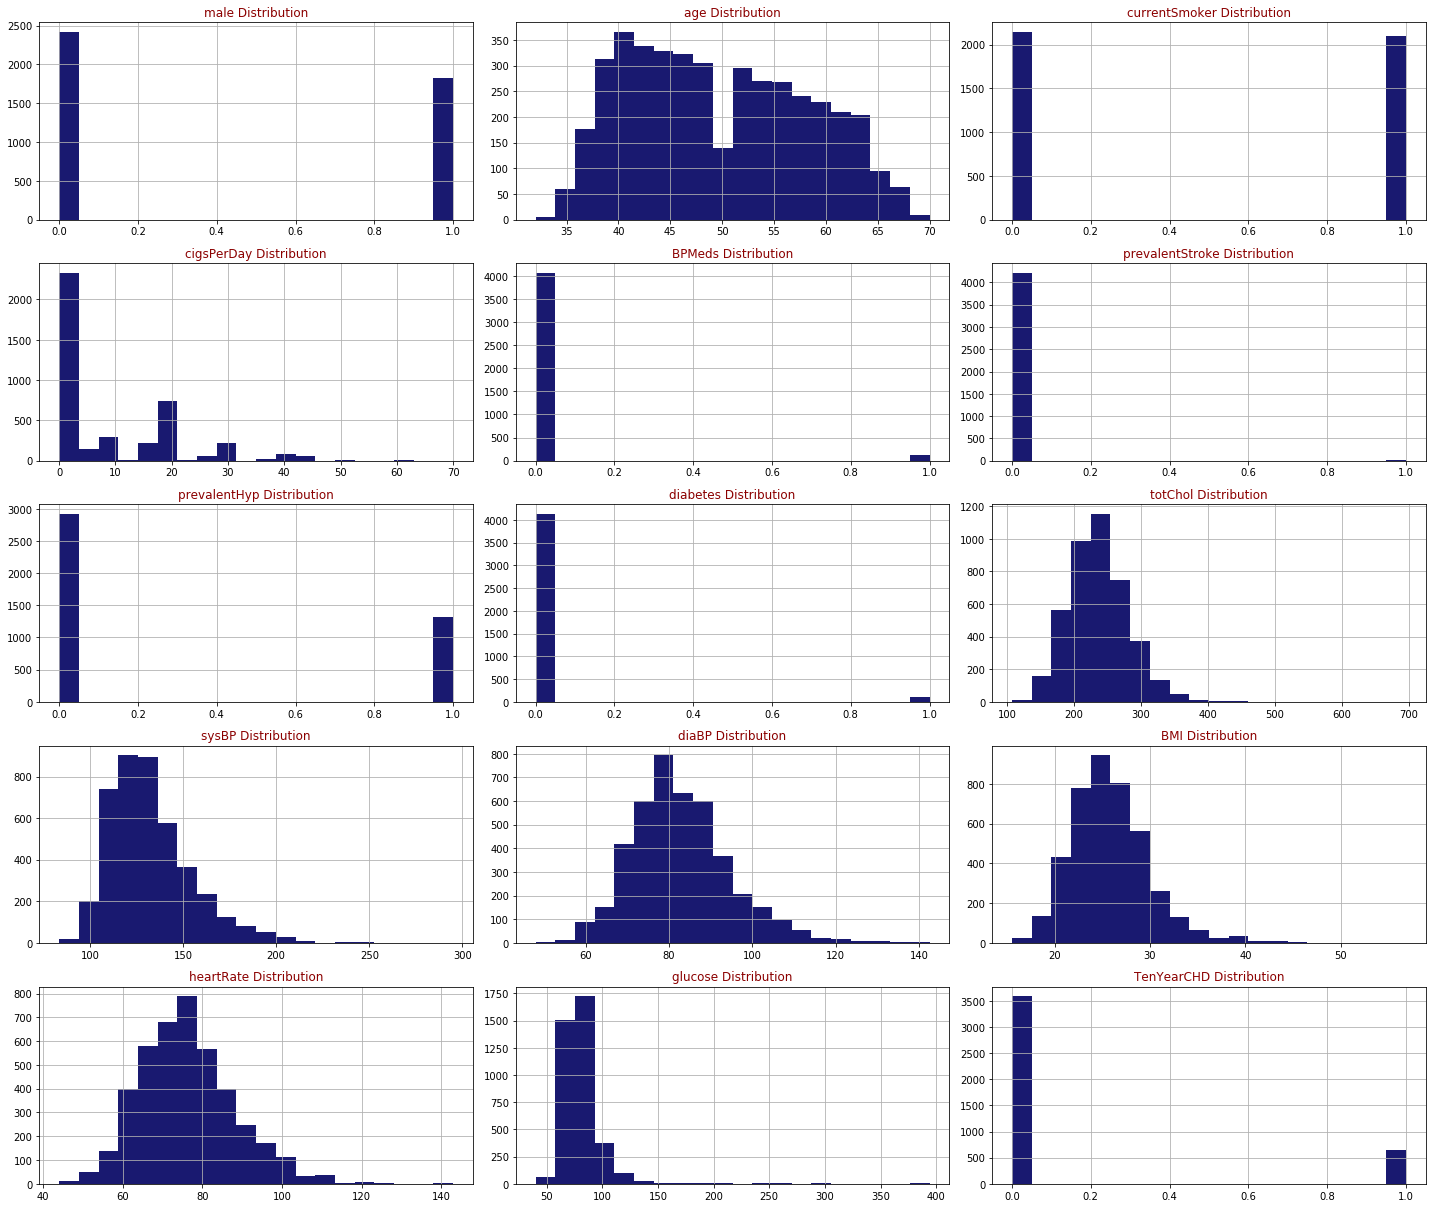

In [41]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(heart_df,heart_df.columns,6,3)

In [42]:
#bảng mô tả feature: trung bình, phương sai, giá trị nhỏ nhất lớn nhất, và giá trị nằm ở từng khoảng 25, 50 75
heart_df.describe()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.000000,4240.000000,4240.000000,4211.000000,4187.000000,4240.000000,4240.000000,4240.000000,4190.000000,4240.000000,4240.000000,4221.000000,4239.000000,3852.000000,4240.000000
mean,0.429245,49.580189,0.494104,9.005937,0.029615,0.005896,0.310613,0.025708,236.699523,132.354599,82.897759,25.800801,75.878981,81.963655,0.151887
std,0.495027,8.572942,0.500024,11.922462,0.169544,0.076569,0.462799,0.158280,44.591284,22.033300,11.910394,4.079840,12.025348,23.954335,0.358953
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [43]:

class LogisticModel:
    def __init__(self,X, y, y_pred=None,num_iters=100,lr=0.001):
        self.X = X
        self.y = y
        self.weight = np.array([0.,0.1,0.1]).reshape(-1,1)
        self.lr = lr
        self.num_iters = num_iters
        self.loss = np.zeros((num_iters,1))
        self.y_predict = np.zeros((X.shape[0],1))

    # Hàm sigmoid
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def forward(self):
        return self.sigmoid(np.dot(self.X, self.weight))

    def grad_0(self):
        return np.sum(self.forward()-self.y) 

    def grad_1(self):
        return np.sum(np.dot(self.X[:,1].reshape(-1),self.forward()-self.y))

    def grad_2(self):
        return np.sum(np.dot(self.X[:,2].reshape(-1),self.forward()-self.y)) 

    def gradient_descend(self):

        for i in range(1, self.num_iters):
            
            if i%10000==0:
                self.y_predict = self.forward()
                print(self.y_predict)
	        # Tính giá trị dự đoán
           
            self.loss[i] = -np.sum(np.multiply(self.y, np.log(self.y_predict)) + np.multiply(1-y, np.log(1-self.y_predict)))
            # Gradient descent
            self.weight -= self.lr * np.dot(self.X.T, self.y_predict-self.y)
            # print(self.weight[0],self.grad_0())
            self.weight[0] -= self.lr * self.grad_0()
            self.weight[1] -= self.lr * self.grad_1()
            self.weight[2] -= self.lr * self.grad_2()



        # Vẽ đường phân cách.
        # print(self.loss)
        print(self.weight)
        t = 0.5
        plt.plot((4, 10),(-(self.weight[0]+4*self.weight[1]+ np.log(1/t-1))/self.weight[2], -(self.weight[0] + 10*self.weight[1]+ np.log(1/t-1))/self.weight[2]), 'g')
        plt.show()


In [50]:
# drop những cột giá trị Nan hoặc không có giá trị
heart_df.dropna(axis=0,inplace=True)

In [51]:
# !pip install statsmodels
from statsmodels.tools import add_constant as add_constant

heart_df_constant = add_constant(heart_df)
heart_df_constant.head()

,const,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1.0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,1.0,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1.0,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,1.0,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,1.0,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [53]:
# so sánh cột cần đánh giá là cột TenYearCHD với những cột còn lại để xem nó là feature có tin cậy hay không
# ngay cột P>|z| chúng ta sẽ lấy những giá trị nào nhỏ hơn 0.005
st.chisqprob = lambda chisq, df: st.chi2.sf(chisq, df)
cols=heart_df_constant.columns[:-1] 
model=sm.Logit(heart_df.TenYearCHD,heart_df_constant[cols])
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.377036
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3736
Method:                           MLE   Df Model:                           14
Date:                Wed, 11 Mar 2020   Pseudo R-squ.:                  0.1170
Time:                        18:00:41   Log-Likelihood:                -1414.3
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 2.439e-71
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.6532      0.687    -12.589      0.000     -10.000      -7.306
male                0.5742      0.107      5.345      0.000       0.364       0.785
age                 0.0641      0.007      9.799      0.000       0.051       0.077
currentSmoker       0.0739      0.155      0.478      0.633      -0.229       0.377
cigsPerDay          0.0184      0.006      3.000      0.003       0.006       0.030
BPMeds              0.1448      0.232      0.623      0.533      -0.310       0.600
prevalentStroke     0.7193      0.489      1.471      0.141      -0.239       1.678
prevalentHyp        0.2142      0.136      1.571      0.116      -0.053       0.481
diabetes            0.0022      0.312      0.007      0.994      -0.610       0.614
totChol             0.0023      0.001      2.081      0.037       0.000       0.004
sysBP               0.0154      0.004      4.082      0.000       0.008       0.023
diaBP              -0.0040      0.006     -0.623      0.533      -0.016       0.009
BMI                 0.0103      0.013      0.827      0.408      -0.014       0.035
heartRate          -0.0023      0.004     -0.549      0.583      -0.010       0.006
glucose             0.0076      0.002      3.409      0.001       0.003       0.012
===================================================================================
"""

In [56]:
def back_feature_elem (data_frame,dep_var,col_list): 
    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        # loại giá trị p cao hơn 0.05
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

result=back_feature_elem(heart_df_constant,heart_df.TenYearCHD,cols)
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3744
Method:                           MLE   Df Model:                            6
Date:                Wed, 11 Mar 2020   Pseudo R-squ.:                  0.1149
Time:                        18:03:34   Log-Likelihood:                -1417.7
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 2.127e-76
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.1264      0.468    -19.504      0.000     -10.043      -8.209
male           0.5815      0.105      5.524      0.000       0.375       0.788
age            0.0655      0.006     10.343      0.000       0.053       0.078
cigsPerDay     0.0197      0.004      4.805      0.000       0.012       0.028
totChol        0.0023      0.001      2.106      0.035       0.000       0.004
sysBP          0.0174      0.002      8.162      0.000       0.013       0.022
glucose        0.0076      0.002      4.574      0.000       0.004       0.011
==============================================================================
"""

In [68]:
import sklearn

new_features=heart_df[['age','male','cigsPerDay','totChol','sysBP','glucose','TenYearCHD']]
x=new_features.iloc[:,:-1]
y=new_features.iloc[:,-1]

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=5)

In [71]:
x_train.shape,y_train.shape

((3000, 6), (3000,))

In [ ]:

class LogisticModel:
    def __init__(self,X, y, y_pred=None,num_iters=100,lr=0.001):
        self.X = X
        self.y = y
        self.weight = np.array([0.,0.1,0.1]).reshape(-1,1)
        self.lr = lr
        self.num_iters = num_iters
        self.loss = np.zeros((num_iters,1))
        self.y_predict = np.zeros((X.shape[0],1))

    # Hàm sigmoid
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def forward(self):
        return self.sigmoid(np.dot(self.X, self.weight))

    def grad_0(self):
        return np.sum(self.forward()-self.y) 

    def grad_1(self):
        return np.sum(np.dot(self.X[:,1].reshape(-1),self.forward()-self.y))

    def grad_2(self):
        return np.sum(np.dot(self.X[:,2].reshape(-1),self.forward()-self.y)) 

    def gradient_descend(self):

        for i in range(1, self.num_iters):
            
            if i%10000==0:
                self.y_predict = self.forward()
                print(self.y_predict)
	        # Tính giá trị dự đoán
           
            self.loss[i] = -np.sum(np.multiply(self.y, np.log(self.y_predict)) + np.multiply(1-y, np.log(1-self.y_predict)))
            # Gradient descent
            self.weight -= self.lr * np.dot(self.X.T, self.y_predict-self.y)
            # print(self.weight[0],self.grad_0())
#             self.weight[0] -= self.lr * self.grad_0()
#             self.weight[1] -= self.lr * self.grad_1()
#             self.weight[2] -= self.lr * self.grad_2()



        # Vẽ đường phân cách.
        # print(self.loss)
        print(self.weight)
        t = 0.5
        plt.plot((4, 10),(-(self.weight[0]+4*self.weight[1]+ np.log(1/t-1))/self.weight[2], -(self.weight[0] + 10*self.weight[1]+ np.log(1/t-1))/self.weight[2]), 'g')
        plt.show()


In [ ]:
model = LogisticModel(x_train,y_train)  

Text(0, 0.5, 'kinh nghiệm (năm)')

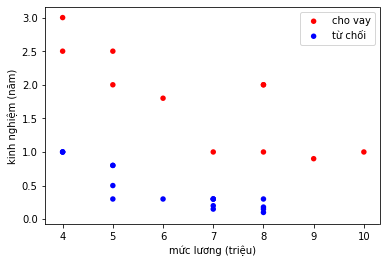

In [91]:
# Vẽ data bằng scatter
data = pd.read_csv('dataset.csv').values
N, d = data.shape
X = data[:, 0:d-1].reshape(-1, d-1)
y = data[:, 2].reshape(-1, 1)
x_cho_vay = X[y[:,0]==1]
x_tu_choi = X[y[:,0]==0]

plt.scatter(x_cho_vay[:, 0], x_cho_vay[:, 1], c='red', edgecolors='none', s=30, label='cho vay')
plt.scatter(x_tu_choi[:, 0], x_tu_choi[:, 1], c='blue', edgecolors='none', s=30, label='từ chối')
plt.legend(loc=1)
plt.xlabel('mức lương (triệu)')
plt.ylabel('kinh nghiệm (năm)')

In [118]:
k = np.array(x_train)
l = np.array(y_train) 
x_bi_benh = k[l[:]==1]
x_khong_benh = k[l[:]==0] 

(480, 6) (2520, 6)


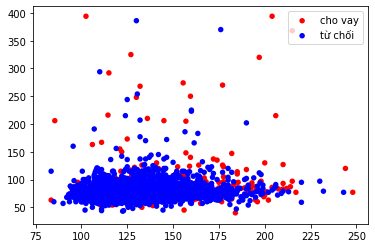

In [128]:
print(x_bi_benh.shape,x_khong_benh.shape)

plt.scatter(x_bi_benh[:, 4], x_bi_benh[:, 5], c='red', edgecolors='none', s=30, label='cho vay')
plt.scatter(x_khong_benh[:, 4], x_khong_benh[:, 5], c='blue', edgecolors='none', s=30, label='từ chối')
plt.legend(loc=1)
# plt.xlabel('mức lương (triệu)')
# plt.ylabel('kinh nghiệm (năm)')

In [120]:
X_true, y_true= handle_data(data)
print("X shape:",X_true.shape,"y shape:",y.shape)
X= np.copy(X_true)
y= np.copy(y_true)

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [14]:
# train model
model.gradient_descend()  
model.weight

//anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


ValueError: operands could not be broadcast together with shapes (3,1) (2,1) (3,1) 